#  Мини-проект

**ПОСТАНОВКА ЗАДАЧИ**

Результаты A/A/B-тестирования от одного известного маркетплейса:

sample_a, sample_c — АА-группы, sample_b — отдельная группа. 

В каждом датасете есть три типа действий пользователей: 
- 0 — клик, 
- 1 — просмотр 
- 2 — покупка 
пользователь просматривает выдачу товаров, кликает на понравившийся товар и совершает покупку.

Маркетплейс ориентируется на следующие метрики:

- ctr (отношение кликов к просмотрам товаров);
- purchase rate (отношение покупок к просмотрам товаров);
- gmv (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

Данные уже почищены по сессиям, вы можете использовать их в агрегированном виде. Ваша задача — понять, нет ли проблемы с разъезжанием сплитов и улучшает ли алгоритм B работу маркетплейса.

Тест Шапиро-Уилка проведите на alpha=0.01

- Что важно как требование к чистоте данных? 
- Посмотрите внимательно на значения метрик!
- «Разъезжаются» ли сплиты? Посмотрите на результаты A/A-теста.
- Каков результат А/B-теста? можем ли мы на него положиться?

**ПЛАН ПРОЕКТА**

- Предварительная обработка датасета

(Проверка, что нет ситуаций, когда происходит покупка/клик без действия просмотра. Удаление дублей.)

- Рассчет метрик по датасетам, общее сравнение метрик.

- Тест равенства долей для A и C групп по всем метрикам.

- Тест равенства долей для A и B групп по всем метрикам.

**ЧТЕНИЕ ДАННЫХ**

In [67]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = r'F:\SkillFactory\Y2_U25_AB'
df_a = pd.read_csv(os.path.join(path,'sample_a.csv'))
df_a.head()

,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0


In [3]:
df_a.action_id.unique()

array([1, 0, 2], dtype=int64)

<AxesSubplot:>

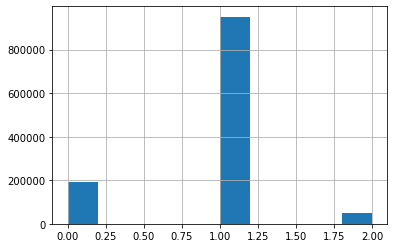

In [4]:
df_a.action_id.hist()

In [5]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188912 entries, 0 to 1188911
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1188912 non-null  int64
 1   item_id    1188912 non-null  int64
 2   action_id  1188912 non-null  int64
dtypes: int64(3)
memory usage: 27.2 MB


In [6]:
#df_a.drop_duplicates()

In [7]:
df_b = pd.read_csv(os.path.join(path,'sample_b.csv'))
df_b.head()

,user_id,item_id,action_id
0,118375,4105,1
1,107569,8204,1
2,175990,880,1
3,160582,9568,0
4,123400,4000,1


In [8]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198438 entries, 0 to 1198437
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1198438 non-null  int64
 1   item_id    1198438 non-null  int64
 2   action_id  1198438 non-null  int64
dtypes: int64(3)
memory usage: 27.4 MB


In [9]:
df_b.action_id.unique()

array([1, 0, 2], dtype=int64)

<AxesSubplot:>

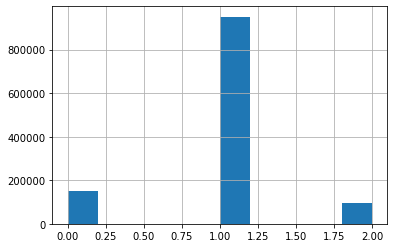

In [10]:
df_b.action_id.hist()

In [11]:
#df_b.drop_duplicates()

In [12]:
df_c = pd.read_csv(os.path.join(path,'sample_c.csv'))
df_c.head()

,user_id,item_id,action_id
0,274623,2863,1
1,265472,343,1
2,242779,6009,0
3,275009,2184,1
4,268104,3134,2


In [13]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205510 entries, 0 to 1205509
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1205510 non-null  int64
 1   item_id    1205510 non-null  int64
 2   action_id  1205510 non-null  int64
dtypes: int64(3)
memory usage: 27.6 MB


In [14]:
df_c.action_id.unique()

array([1, 0, 2], dtype=int64)

<AxesSubplot:>

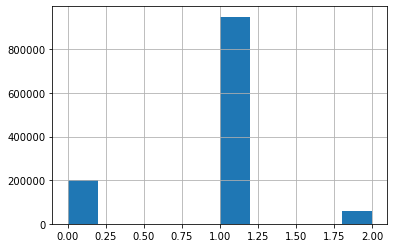

In [15]:
df_c.action_id.hist()

In [16]:
df_prices = pd.read_csv(os.path.join(path,'item_prices.csv'))
df_prices.head()

,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804


In [17]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   item_id     1000 non-null   int64
 1   item_price  1000 non-null   int64
dtypes: int64(2)
memory usage: 15.8 KB


**ПОДГОТОВКА ДАННЫХ**

In [18]:
def create_dataframe(df, dict_actions):
    
    '''
    Формирует датасет в соответствии со словарем
    dict_actions = {0:'click', 1:'view', 2: 'buy'}
    по количеству совершенных действий
    '''
    #click
    l_keys = list(dict_actions.keys())
    df0 = df[df.action_id==l_keys[0]].groupby(['user_id','item_id']).count()
    df0.rename({'action_id':dict_actions[l_keys[0]]}, axis=1,inplace=True)
    
    for i in range(1,len(l_keys)):
        
        df0 = df0.merge(df[df.action_id==l_keys[i]].groupby(['user_id','item_id']).count(),\
             left_on=['user_id','item_id'], right_on=['user_id','item_id'],\
             how='outer')
        df0.rename({'action_id':dict_actions[l_keys[i]]}, axis=1,inplace=True)
    
    df0 = df0.reset_index()
    df0 = df0.merge(df_prices, left_on='item_id', right_on='item_id',how='outer') 
            
    return df0

In [19]:
# Словарь действий
dict_actions = {0:'click', 1:'view', 2: 'buy'}

In [20]:
list(dict_actions.keys())

[0, 1, 2]

In [21]:
df_a = create_dataframe(df_a, dict_actions)

In [22]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995950 entries, 0 to 995949
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     995950 non-null  int64  
 1   item_id     995950 non-null  int64  
 2   click       199253 non-null  float64
 3   view        995950 non-null  int64  
 4   buy         49748 non-null   float64
 5   item_price  995950 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 53.2 MB


In [23]:
df_a.isnull().sum()

user_id            0
item_id            0
click         796697
view               0
buy           946202
item_price         0
dtype: int64

In [24]:
df_a = df_a.fillna(0)

In [25]:
df_a.sample(10)

,user_id,item_id,click,view,buy,item_price
202416,5880,1081,0.0,1,0.0,1578
206324,88708,1304,1.0,1,0.0,1460
390106,21356,3387,0.0,1,0.0,206
454079,91715,8067,0.0,1,0.0,1942
39597,71214,2401,0.0,1,0.0,1670
134595,67337,7254,1.0,1,0.0,1440
153128,69637,8054,0.0,1,0.0,130
597777,1939,2300,0.0,1,0.0,1073
253889,95415,3890,0.0,1,0.0,497
427910,55584,6186,0.0,1,0.0,1976


In [26]:
df_a.describe()

,user_id,item_id,click,view,buy,item_price
count,995950.000000,995950.000000,995950.000000,995950.0,995950.000000,995950.000000
mean,49583.513347,4977.483219,0.200063,1.0,0.049950,1065.755003
std,29209.221992,2866.995602,0.400048,0.0,0.217842,556.826342
min,241.000000,21.000000,0.000000,1.0,0.000000,102.000000
25%,25141.000000,2568.000000,0.000000,1.0,0.000000,591.750000
50%,48358.000000,4869.000000,0.000000,1.0,0.000000,1062.000000
75%,75580.000000,7580.000000,0.000000,1.0,0.000000,1568.000000
max,99880.000000,9994.000000,1.000000,1.0,1.000000,1998.000000


In [27]:
df_b = create_dataframe(df_b, dict_actions)

In [28]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995961 entries, 0 to 995960
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     995961 non-null  int64  
 1   item_id     995961 non-null  int64  
 2   click       159294 non-null  float64
 3   view        995961 non-null  int64  
 4   buy         99472 non-null   float64
 5   item_price  995961 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 53.2 MB


In [29]:
df_b.isnull().sum()

user_id            0
item_id            0
click         836667
view               0
buy           896489
item_price         0
dtype: int64

In [30]:
df_b = df_b.fillna(0)

In [31]:
df_b.sample(10)

,user_id,item_id,click,view,buy,item_price
418281,196642,190,0.0,1,0.0,1695
568168,138067,4884,0.0,1,0.0,1898
641942,146765,7162,0.0,1,0.0,579
907840,171331,5121,0.0,1,0.0,1340
688786,149051,6043,0.0,1,0.0,154
300256,137533,9426,0.0,1,0.0,861
579435,173416,6302,0.0,1,0.0,286
621649,100949,4196,0.0,1,0.0,947
679287,124702,4873,1.0,1,1.0,607
199006,187876,1915,0.0,1,0.0,1538


In [32]:
df_b.describe()

,user_id,item_id,click,view,buy,item_price
count,995961.000000,995961.000000,995961.000000,995961.0,995961.000000,995961.000000
mean,149708.467707,4977.461039,0.159940,1.0,0.099875,1065.752183
std,28669.576226,2867.000867,0.366551,0.0,0.299834,556.829088
min,100038.000000,21.000000,0.000000,1.0,0.000000,102.000000
25%,123400.000000,2568.000000,0.000000,1.0,0.000000,591.000000
50%,149944.000000,4865.000000,0.000000,1.0,0.000000,1062.000000
75%,174059.000000,7580.000000,0.000000,1.0,0.000000,1568.000000
max,199966.000000,9994.000000,1.000000,1.0,1.000000,1998.000000


In [33]:
df_c = create_dataframe(df_c, dict_actions)

In [34]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 993951 entries, 0 to 993950
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     993951 non-null  int64  
 1   item_id     993951 non-null  int64  
 2   click       208682 non-null  float64
 3   view        993951 non-null  int64  
 4   buy         59689 non-null   float64
 5   item_price  993951 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 53.1 MB


In [35]:
df_c.isnull().sum()

user_id            0
item_id            0
click         785269
view               0
buy           934262
item_price         0
dtype: int64

In [36]:
df_c = df_c.fillna(0)

In [37]:
df_c.sample(10)

,user_id,item_id,click,view,buy,item_price
152181,254539,7264,1.0,1,0.0,1272
978276,200790,9433,0.0,1,0.0,1921
96260,281232,3997,0.0,1,0.0,1452
865916,281756,9508,1.0,1,0.0,1817
494268,215516,9679,0.0,1,0.0,500
195826,209843,9195,1.0,1,0.0,1754
19678,275444,810,0.0,1,1.0,1343
884000,225947,6888,0.0,1,0.0,435
840566,261639,880,0.0,1,0.0,846
590323,288628,9958,0.0,1,0.0,265


In [38]:
df_c.describe()

,user_id,item_id,click,view,buy,item_price
count,993951.000000,993951.000000,993951.000000,993951.0,993951.000000,993951.000000
mean,251008.676147,4977.479591,0.209952,1.0,0.060052,1065.759685
std,28199.468854,2867.003237,0.407274,0.0,0.237584,556.828666
min,200225.000000,21.000000,0.000000,1.0,0.000000,102.000000
25%,227764.000000,2568.000000,0.000000,1.0,0.000000,591.000000
50%,251519.000000,4865.000000,0.000000,1.0,0.000000,1062.000000
75%,275512.000000,7580.000000,0.000000,1.0,0.000000,1569.000000
max,299828.000000,9994.000000,1.000000,1.0,1.000000,1998.000000


**Вывод**: из описаний статистик датасетов видно, что 
1. все записи признака 'view' во всех датасетах =1
2. признак 'item_price' имеет совпадающие статистики во всех трех датасетах

Для наглядности постоим гистограммы распределения цен в датасетах: 

array([[<AxesSubplot:title={'center':'item_price'}>]], dtype=object)

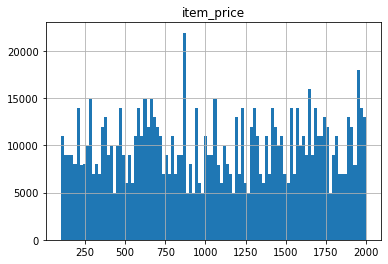

In [39]:
df_a[['item_price']].hist(bins=100)

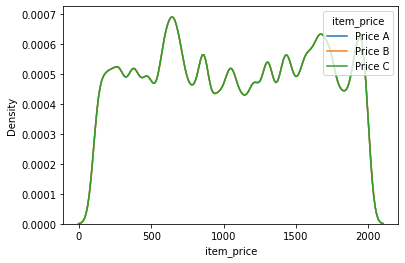

In [40]:
sns.distplot(df_a['item_price'], hist=False, label='Price A')
sns.distplot(df_b['item_price'], hist=False, label='Price B')
sns.distplot(df_c['item_price'], hist=False, label='Price C')
plt.legend(title='item_price', loc='upper right')    

array([[<AxesSubplot:title={'center':'click'}>,
        <AxesSubplot:title={'center':'buy'}>]], dtype=object)

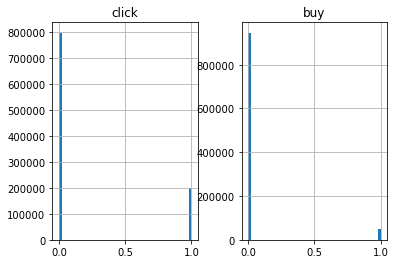

In [41]:
df_a[['click','buy']].hist(bins=50)

<AxesSubplot:>

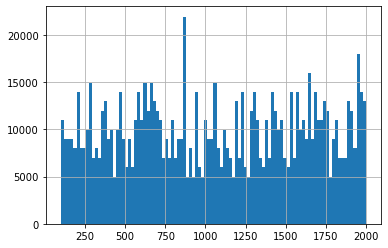

In [42]:
df_b.item_price.hist(bins=100)

array([[<AxesSubplot:title={'center':'click'}>,
        <AxesSubplot:title={'center':'buy'}>]], dtype=object)

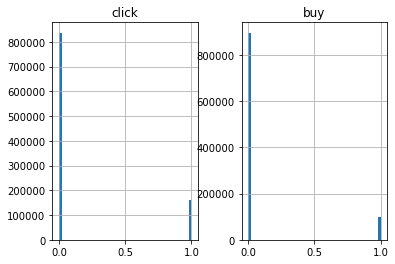

In [43]:
df_b[['click','buy']].hist(bins=50)

<AxesSubplot:>

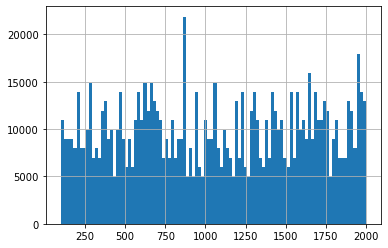

In [44]:
df_c.item_price.hist(bins=100)

array([[<AxesSubplot:title={'center':'click'}>,
        <AxesSubplot:title={'center':'buy'}>]], dtype=object)

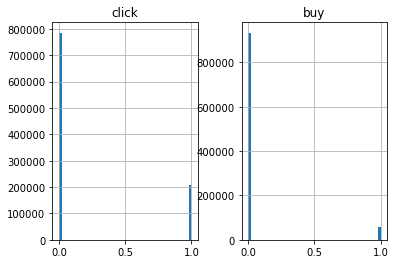

In [45]:
df_c[['click','buy']].hist(bins=50)

Из гистограмм распределения цен элементов видно, что наши группы не имеют визуального расхождения, поэтому можно продолжить преобразования датасетов и построить метрики 

**ПОСТРОЕНИЕ МЕТРИК**

Маркетплейс ориентируется на следующие метрики:

ctr (отношение кликов к просмотрам товаров);
purchase rate (отношение покупок к просмотрам товаров);
gmv (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

In [46]:
def summary(x):
    result = {
        'click': x['click'].sum(),
        'view': x['view'].sum(),
        'buy': x['buy'].sum(),
        'gmv': x['sum_buy'].sum(),
    }
    return pd.Series(result).round(0)

In [47]:
def create_metrics(df):
    '''
    Создает метрики
    '''
    df['sum_buy'] = df['buy'] * df['item_price']
    df1 = df.groupby('user_id').apply(summary)
    
    df1['ctr'] = df1['click']/df1['view']
    df1['purchase_rate'] = df1['buy']/df1['view']
    
    return df1

In [48]:
def test_shapiro(sample, alpha, text):
    '''
    Тест Шапиро-Уилка
    sample - выборка
    alpha - 
    '''
    stat, p = shapiro(sample)
    print('Статистика=%.3f, p=%.3f' % (stat, p))
    # interpret
    
    if p > alpha:
        print(f'Выборка {text} выглядит гауссовой (не удается отклонить H0)')
    else:
        print(f'Выборка {text} не выглядит Гауссовой (отклонить H0)')

In [77]:
def _kde(feature):
    '''
    Сравнение признаков по группам
    '''
    sns.kdeplot(x=feature, data=dfa, common_norm=False, label='A');
    sns.kdeplot(x=feature, data=dfb, common_norm=False, label='B');
    sns.kdeplot(x=feature, data=dfc, common_norm=False, label='C');
    plt.legend(title=feature, loc='upper right')    
    plt.title("Kernel Density Function");

**A**

In [49]:
dfa = create_metrics(df_a)
dfa.head(10)

,click,view,buy,gmv,ctr,purchase_rate
user_id,,,,,,
241,186.0,1000.0,48.0,48232.0,0.186,0.048
253,201.0,1000.0,37.0,38676.0,0.201,0.037
362,186.0,1000.0,52.0,61392.0,0.186,0.052
378,206.0,1000.0,53.0,60223.0,0.206,0.053
475,209.0,1000.0,54.0,53476.0,0.209,0.054
478,199.0,1000.0,52.0,53779.0,0.199,0.052
486,212.0,1000.0,47.0,40677.0,0.212,0.047
963,181.0,1000.0,53.0,57460.0,0.181,0.053
964,184.0,1000.0,46.0,44086.0,0.184,0.046


In [50]:
dfa.describe()

,click,view,buy,gmv,ctr,purchase_rate
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,200.053213,999.949799,49.947791,53273.270080,0.200063,0.049950
std,13.435653,0.227483,7.226785,8573.875661,0.013438,0.007228
min,164.000000,998.000000,27.000000,28890.000000,0.164000,0.027000
25%,191.000000,1000.000000,45.000000,47413.500000,0.191000,0.045000
50%,199.000000,1000.000000,50.000000,52892.000000,0.199100,0.050000
75%,208.250000,1000.000000,54.000000,59091.500000,0.208406,0.054014
max,241.000000,1000.000000,74.000000,79722.000000,0.241000,0.074000


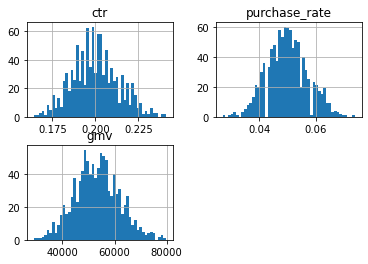

In [51]:
dfa[['ctr','purchase_rate','gmv']].hist(bins=50);

In [52]:
test_shapiro(dfa['ctr'], 0.01, 'A ctr')

Статистика=0.995, p=0.004
Выборка A ctr не выглядит Гауссовой (отклонить H0)


In [108]:
test_shapiro(dfa['ctr'], 0.05, 'A ctr')

Статистика=0.995, p=0.004
Выборка A ctr не выглядит Гауссовой (отклонить H0)


In [109]:
test_shapiro(dfa['purchase_rate'], 0.01, 'A purchase_rate')

Статистика=0.996, p=0.011
Выборка A purchase_rate выглядит гауссовой (не удается отклонить H0)


In [110]:
test_shapiro(dfa['gmv'], 0.01, 'A gmv')

Статистика=0.997, p=0.125
Выборка A gmv выглядит гауссовой (не удается отклонить H0)


**B**

In [55]:
dfb = create_metrics(df_b)
dfb.head(10)

,click,view,buy,gmv,ctr,purchase_rate
user_id,,,,,,
100038,176.0,1000.0,104.0,106996.0,0.176,0.104
100099,169.0,1000.0,123.0,133374.0,0.169,0.123
100164,153.0,1000.0,101.0,103207.0,0.153,0.101
100321,187.0,1000.0,99.0,103841.0,0.187,0.099
100397,159.0,1000.0,86.0,95020.0,0.159,0.086
100696,150.0,1000.0,93.0,107065.0,0.150,0.093
100949,177.0,1000.0,94.0,100167.0,0.177,0.094
101079,170.0,1000.0,125.0,135714.0,0.170,0.125
101121,174.0,1000.0,84.0,91532.0,0.174,0.084


In [56]:
dfb.describe()

,click,view,buy,gmv,ctr,purchase_rate
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,159.933735,999.960843,99.871486,106473.271084,0.159940,0.099875
std,12.484428,0.199176,9.996158,11838.455338,0.012485,0.009996
min,115.000000,998.000000,68.000000,71245.000000,0.115000,0.068000
25%,151.000000,1000.000000,93.000000,98393.750000,0.151151,0.093000
50%,160.000000,1000.000000,100.000000,106192.000000,0.160000,0.100000
75%,168.000000,1000.000000,107.000000,114606.500000,0.168000,0.107000
max,198.000000,1000.000000,130.000000,144133.000000,0.198000,0.130000


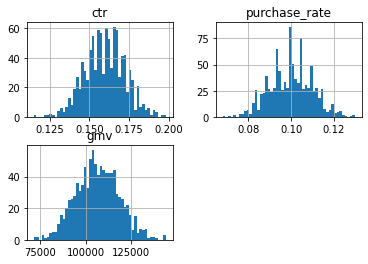

In [57]:
dfb[['ctr','purchase_rate','gmv']].hist(bins=50);

In [58]:
test_shapiro(dfb['ctr'], 0.01, 'B ctr')

Статистика=0.999, p=0.710
Выборка B ctr выглядит гауссовой (не удается отклонить H0)


In [59]:
test_shapiro(dfb['purchase_rate'], 0.01, 'B purchase_rate')

Статистика=0.998, p=0.277
Выборка B purchase_rate выглядит гауссовой (не удается отклонить H0)


In [60]:
test_shapiro(dfb['gmv'], 0.01, 'B gmv')

Статистика=0.999, p=0.846
Выборка B gmv выглядит гауссовой (не удается отклонить H0)


**C**

In [61]:
dfc = create_metrics(df_c)
dfc.head(10)

,click,view,buy,gmv,ctr,purchase_rate
user_id,,,,,,
200225,206.0,1000.0,50.0,51077.0,0.206000,0.050000
200278,213.0,1000.0,60.0,58453.0,0.213000,0.060000
200282,218.0,1000.0,73.0,86997.0,0.218000,0.073000
200325,194.0,1000.0,47.0,51910.0,0.194000,0.047000
200441,212.0,999.0,51.0,53939.0,0.212212,0.051051
200476,193.0,1000.0,63.0,56285.0,0.193000,0.063000
200581,213.0,1000.0,59.0,59732.0,0.213000,0.059000
200582,204.0,1000.0,63.0,64593.0,0.204000,0.063000
200672,205.0,1000.0,54.0,60105.0,0.205000,0.054000


In [62]:
dfc.describe()

,click,view,buy,gmv,ctr,purchase_rate
count,994.00000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,209.94165,999.950704,60.049296,63998.903421,0.209952,0.060052
std,12.65216,0.242894,7.991976,9562.844625,0.012651,0.007992
min,174.00000,997.000000,35.000000,36694.000000,0.174000,0.035000
25%,201.00000,1000.000000,55.000000,57542.250000,0.201000,0.055000
50%,211.00000,1000.000000,60.000000,63816.000000,0.211000,0.060000
75%,218.00000,1000.000000,65.000000,69937.500000,0.218000,0.065000
max,250.00000,1000.000000,92.000000,107534.000000,0.250000,0.092000


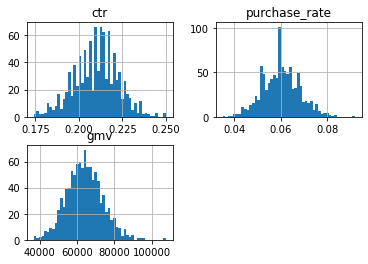

In [63]:
dfc[['ctr','purchase_rate','gmv']].hist(bins=50);

In [64]:
test_shapiro(dfc['ctr'], 0.01, 'C ctr')

Статистика=0.997, p=0.130
Выборка C ctr выглядит гауссовой (не удается отклонить H0)


In [65]:
test_shapiro(dfc['purchase_rate'], 0.01, 'C purchase_rate')

Статистика=0.997, p=0.087
Выборка C purchase_rate выглядит гауссовой (не удается отклонить H0)


In [66]:
test_shapiro(dfc['gmv'], 0.01, 'C gmv')

Статистика=0.996, p=0.020
Выборка C gmv выглядит гауссовой (не удается отклонить H0)


**Выводы:**

Построенные метрики на всех трех датасетах, как показывают гистограммы распределений и тесты Шапиро Уилка имеют нормальные распределения с достоверностью 99%.
Исключение составляет метрика **ctr** на датасете **А** : тест Шапиро - Уилка отклоняет нулевую гипотезу о нормальности распределения p=0.004 < 0.01

Посмотрим на функции плотности ядра полученных распределений для каждого датасета:

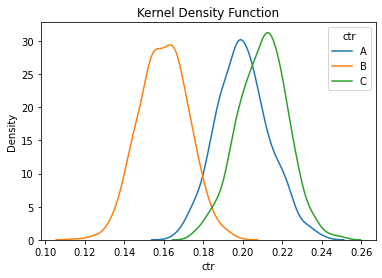

In [111]:
_kde('ctr')

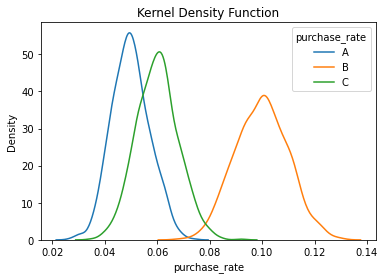

In [112]:
_kde('purchase_rate')

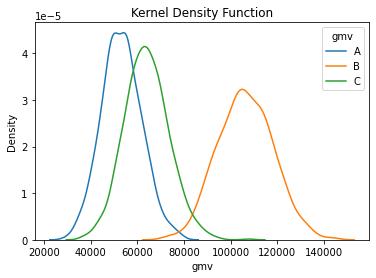

In [113]:
_kde('gmv')

Визуально можно отметить сходное поведение метрик на наборах А и С, при этом на датасете С количество кликов, покупок и в целом оборот по покупкам несколько больше, чем на датасете А, хотя от датасетов А и С мы ожидали очень близкого поведения. Это должно навести на мысль об условиях проведения тестов. Поэтому значительные повышения метрик по покупкам и обороту на тесте В могут вызвать вопросы. Если датасеты А и С обладают почти одинаковой дисперсией, то датасет В имеет гораздо больший разброс значений.

In [85]:
df_a['click'].sum(),df_c['click'].sum()

(199253.0, 208682.0)

In [89]:
df_a['view'].sum(),df_c['view'].sum(),df_a['view'].count(),df_c['view'].count(),len(df_a['view']),len(df_c['view'])

(995950, 993951, 995950, 993951, 995950, 993951)

**Тест равенства долей для A и C групп**

Для тестирования равенства долей используем Z-тест. Нулевая гипотеза о равенстве долей в группах

In [150]:
def report_test(stat, p_value, significance):
    
    # report
    print('z_stat: %0.3f, p_value: %0.10f' % (stat, p_value))

    if p_value > significance:
       print ("Не удалось отвергнуть нулевую гипотезу")
    else:
       print ("Отклонить нулевую гипотезу - предположить, что группы различаются")

Для отношения кликов к просмотрам

In [151]:
# can we assume anything from our sample
significance = 0.01

# check our sample against Ho for Ha > Ho
# for Ha < Ho use alternative='smaller'
# for Ha != Ho use alternative='two-sided'
stat, p_value = proportions_ztest(count=[df_a['click'].sum(), df_c['click'].sum()],\
                                  nobs=[df_a['view'].sum(), df_c['view'].sum()])
#                                 value=null_hypothesis,alternative='larger')

report_test(stat, p_value, significance)

z_stat: -17.277, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


Для отношения покупок к просмотрам

In [152]:
# can we assume anything from our sample
significance = 0.01

# check our sample against Ho for Ha > Ho
# for Ha < Ho use alternative='smaller'
# for Ha != Ho use alternative='two-sided'
stat, p_value = proportions_ztest(count=[df_a['buy'].sum(), df_c['buy'].sum()],\
                                  nobs=[df_a['view'].sum(), df_c['view'].sum()])
#                                 value=null_hypothesis,alternative='larger')

report_test(stat, p_value, significance)

z_stat: -31.254, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


Посмотрим двухвыборочный тест по всем метрикам:

In [153]:
stat, p_value = stats.ttest_ind(dfa['ctr'], dfc['ctr'])
report_test(stat, p_value, significance)

z_stat: -16.900, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


In [154]:
stat, p_value = stats.ttest_ind(dfa['purchase_rate'], dfc['purchase_rate'])
report_test(stat, p_value, significance)

z_stat: -29.573, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


In [155]:
stat, p_value = stats.ttest_ind(dfa['gmv'], dfc['gmv'])
report_test(stat, p_value, significance)

z_stat: -26.343, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


**Гипотезы отвергаются во всех случаях: pvalue<0.01**

**Тест равенства долей для A и B групп**

Для отношения кликов к просмотрам

In [156]:
# can we assume anything from our sample
significance = 0.01

# check our sample against Ho for Ha > Ho
# for Ha < Ho use alternative='smaller'
# for Ha != Ho use alternative='two-sided'
stat, p_value = proportions_ztest(count=[df_a['click'].sum(), df_b['click'].sum()],\
                                  nobs=[df_a['view'].sum(), df_b['view'].sum()])
#                                 value=null_hypothesis,alternative='larger')

report_test(stat, p_value, significance)

z_stat: 73.698, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


Для отношения покупок к просмотрам

In [157]:
# can we assume anything from our sample
significance = 0.01

# check our sample against Ho for Ha > Ho
# for Ha < Ho use alternative='smaller'
# for Ha != Ho use alternative='two-sided'
stat, p_value = proportions_ztest(count=[df_a['buy'].sum(), df_b['buy'].sum()],\
                                  nobs=[df_a['view'].sum(), df_b['view'].sum()])
#                                 value=null_hypothesis,alternative='larger')

report_test(stat, p_value, significance)

z_stat: -133.830, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


Посмотрим двухвыборочный тест по всем метрикам:

In [158]:
stat, p_value = stats.ttest_ind(dfa['ctr'], dfb['ctr'])
report_test(stat, p_value, significance)

z_stat: 69.035, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


In [159]:
stat, p_value = stats.ttest_ind(dfa['purchase_rate'], dfb['purchase_rate'])
report_test(stat, p_value, significance)

z_stat: -127.732, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


In [160]:
stat, p_value = stats.ttest_ind(dfa['gmv'], dfb['gmv'])
report_test(stat, p_value, significance)

z_stat: -114.863, p_value: 0.0000000000
Отклонить нулевую гипотезу - предположить, что группы различаются


**Гипотезы отвергаются во всех случаях: pvalue<0.01**

**Несмотря на впечатляющие результаты A/B теста положиться на него нельзя, при A/A - тестировании уже заметно существенное различие** 